<a href="https://colab.research.google.com/github/ErickMartinezz/AprendizajeAutomatico2/blob/main/AA2_TP2_MLP_KAN_ErickMartinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 AA2 MLP vs KAN

**COLOQUE SU NOMBRE AQUI**

Tema: **Comparación entre MLP (Perceptrón Multicapa) y KAN (Kolmogorov-Arnold Networks) en problemas de regresión**

* Utilice este notebook como su diario de aprendizaje en esta materia.
* Mencione las herramientas utilizadas.
* Describa sus dificultades y como pudo sortearlas.
* Grafique las curvas de entrenamiento y testeo para cada configuración probada en sus modelos.


## **Objetivos:**  
1. Generar un conjunto de datos sintéticos para un problema de regresión.  
2. Implementar y evaluar una **MLP de una capa oculta** en diferentes configuraciones.  
3. Implementar y evaluar una **red KAN** en diferentes configuraciones.  
4. Analizar los casos de **underfitting**, **sobreajuste (overfitting)** y una **solución aceptable** en ambos modelos.  




## **Instrucciones Detalladas:**  

### **1. Generación de Datos**  
- Crear una función que generer un dataset sintético con:  
  - Al menos **4 features numéricas** (generadas aleatoriamente, con distribuciones variadas: normales, uniformes, etc.).  
  - **1 target continuo** (generado mediante una combinación **no** lineal de las features + ruido gaussiano).  
  - Ejemplo:  
    ```python
    import numpy as np
    np.random.seed(42)
    X = np.random.randn(1000, 4)  # 1000 muestras, 4 features
    y = 2 * X[:, 0] + np.sin(X[:, 1]) + np.cos(X[:, 2]) * X[:, 3] + 0.1 * np.random.randn(1000)
    ```  
  - **Dividir los datos** en entrenamiento (70%) y test (30%).  


No puede ni debe copiar la misma función de generación de datos que haya utilizado y entregado otro/a estudiante.

In [15]:
# Generación de Datos Sintéticos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Fijar semilla para reproducibilidad
np.random.seed(42)

# Número de muestras
n = 1000

# Generación de 4 features con distintas distribuciones
X1 = np.random.normal(loc=0, scale=1, size=n)          # Distribución normal estándar
X2 = np.random.uniform(low=-3, high=3, size=n)          # Distribución uniforme
X3 = np.random.exponential(scale=1.0, size=n)           # Distribución exponencial
X4 = np.random.normal(loc=5, scale=2, size=n)           # Otra normal, desplazada

# Combinar en una matriz (features)
X = np.column_stack((X1, X2, X3, X4))

# Generar target continuo (combinación no lineal + ruido)
y = (1.5 * X1**2 + np.sin(X2) + np.log1p(X3) - 0.3 * X4 + 0.2 * np.random.randn(n))   # ruido gaussiano

# Convertir a DataFrame (opcional, útil para visualizar)
df = pd.DataFrame(X, columns=['feature1', 'feature2', 'feature3', 'feature4'])
df['target'] = y

# Dividir en entrenamiento (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Mostrar forma de los conjuntos resultantes
print("Forma del conjunto de entrenamiento:", X_train.shape)
print("Forma del conjunto de prueba:", X_test.shape)
print(df.head())


Forma del conjunto de entrenamiento: (700, 4)
Forma del conjunto de prueba: (300, 4)
   feature1  feature2  feature3  feature4    target
0  0.496714 -1.995105  0.247268  3.786599 -1.650936
1 -0.138264 -2.372593  0.037413  5.422567 -2.055355
2  0.647689  0.818581  0.114318  7.400158 -0.685148
3  1.523030  1.238854  0.413791  4.016195  3.520762
4 -0.234153 -2.810483  1.622451  1.246895  0.182403


### **2. Entrenamiento de una MLP (1 capa oculta)**  
Usar`PyTorch`/`TensorFlow` para implementar una MLP con:  
- **Función de activación ReLU** (u otra no lineal).  
- **Optimizador:** Adam o SGD.  
- **Métrica de evaluación:** Error Cuadrático Medio (MSE).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Pocas neuronas en la capa oculta (ej: 2 neuronas).  
   - Entrenar con muy pocas épocas (ej: 10).  
   - Mostrar gráficos de pérdida y comparar rendimiento en train/test.  

2. **Solución Aceptable:**  
   - Neuronas suficientes (ej: 20-50) y épocas adecuadas (ej: 100).  
   - Regularización L2 (weight decay) si es necesario.  

3. **Overfitting:**  
   - Demasiadas neuronas (ej: 200) o muchas épocas (ej: 1000).  
   - Sin regularización.  
   - Mostrar cómo el error en entrenamiento es mucho menor que en test.  


In [16]:
# Entrenamiento de una MLP (1 capa oculta)


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Convertir datos a tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)


In [17]:
# Función genérica para crear y entrenar una MLP

def train_mlp(hidden_neurons=10, epochs=100, lr=0.01, weight_decay=0.0, plot_title="Modelo"):
    model = nn.Sequential(
        nn.Linear(4, hidden_neurons),  # capa oculta
        nn.ReLU(),
        nn.Linear(hidden_neurons, 1)   # salida
    )

    # Definir pérdida y optimizador
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Entrenamiento
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Modo entrenamiento
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = criterion(y_pred, y_train_t)
        loss.backward()
        optimizer.step()

        # Evaluar en test
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test_t)
            test_loss = criterion(test_pred, y_test_t)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())


            # Gráfico de pérdida
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(plot_title)
    plt.xlabel("Época")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()
        # MSE final
    y_train_pred = model(X_train_t).detach().numpy()
    y_test_pred  = model(X_test_t).detach().numpy()
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test  = mean_squared_error(y_test, y_test_pred)

    print(f"🔹 {plot_title}")
    print(f"MSE entrenamiento: {mse_train:.4f}")
    print(f"MSE test:          {mse_test:.4f}")
    print("-" * 40)

    return model

In [18]:
# Comparación 2D: Real vs Predicho

def comparar_modelos_2d(modelos, nombres_modelos, X_test, y_test):

    plt.figure(figsize=(14, 4))

    # Convertir y_test a numpy si es tensor
    if isinstance(y_test, torch.Tensor):
        y_test_np = y_test.detach().numpy()
    else:
        y_test_np = y_test

    for i, (modelo, nombre) in enumerate(zip(modelos, nombres_modelos), start=1):
        modelo.eval()
        with torch.no_grad():
            y_pred = modelo(torch.tensor(X_test, dtype=torch.float32)).numpy()

        plt.subplot(1, len(modelos), i)
        plt.scatter(y_test_np, y_pred, alpha=0.5, color='red', label='Predicciones')
        plt.plot(y_test_np, y_test_np, color='blue', linestyle='--', label='Ideal (y=x)')
        plt.title(nombre)
        plt.xlabel("Target Real")
        plt.ylabel("Predicho")
        plt.legend()
        plt.grid(True)

    plt.suptitle("Comparación de Modelos: Real vs Predicho", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



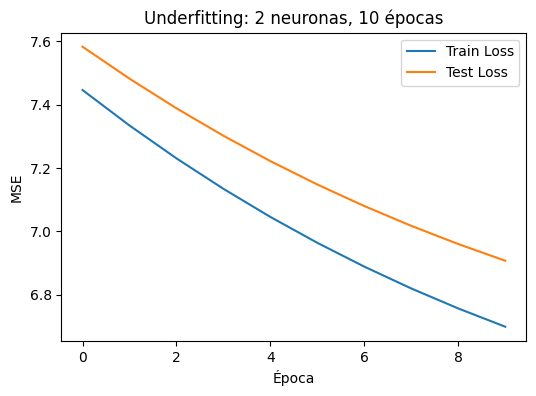

🔹 Underfitting: 2 neuronas, 10 épocas
MSE entrenamiento: 6.6463
MSE test:          6.9073
----------------------------------------


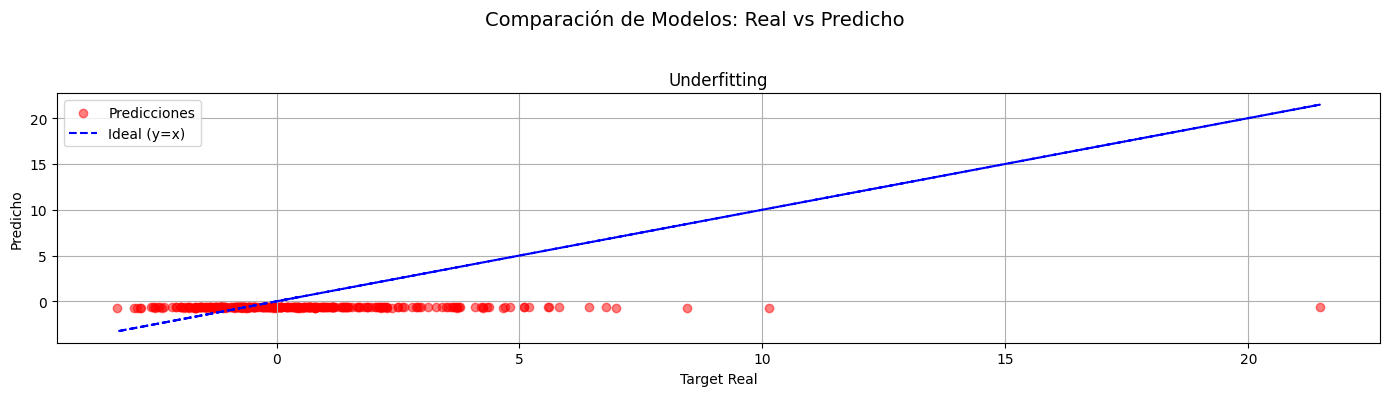

In [19]:
# Entrenar los tres modelos
modelo_under = train_mlp(hidden_neurons=2, epochs=10, lr=0.01, plot_title="Underfitting: 2 neuronas, 10 épocas")

# Comparar en un gráfico 2D
comparar_modelos_2d(
    modelos=[modelo_under],
    nombres_modelos=["Underfitting"],
    X_test=X_test,
    y_test=y_test
)


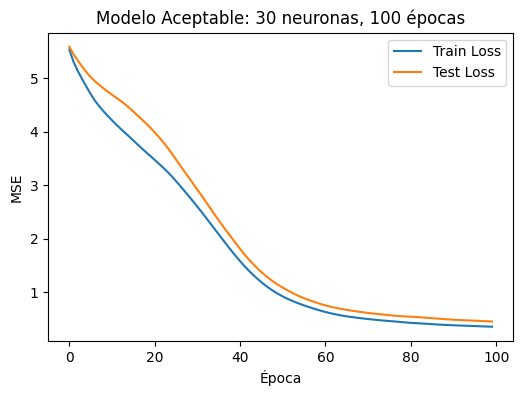

🔹 Modelo Aceptable: 30 neuronas, 100 épocas
MSE entrenamiento: 0.3483
MSE test:          0.4479
----------------------------------------


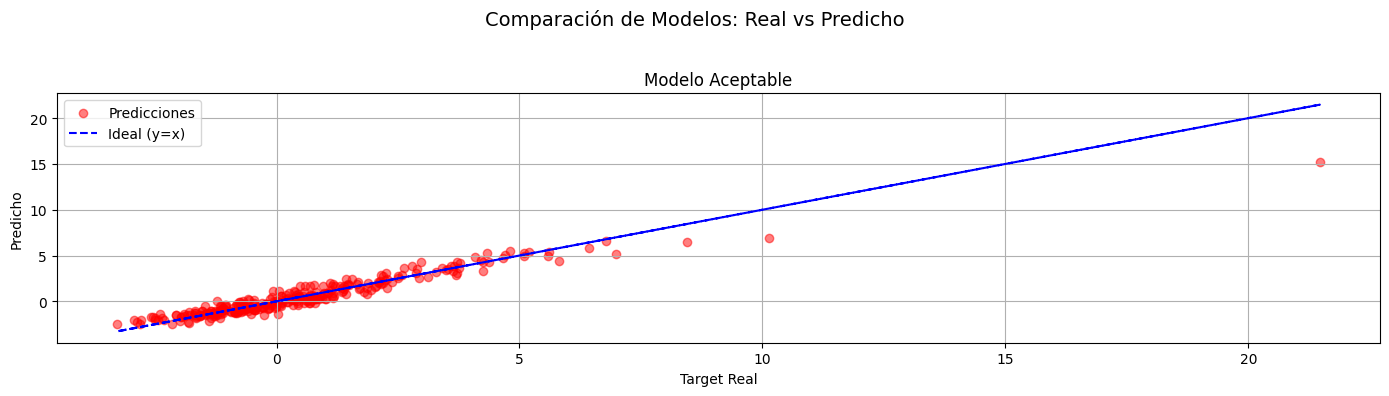

In [6]:
modelo_ok = train_mlp(hidden_neurons=30, epochs=100, lr=0.01, weight_decay=1e-4, plot_title="Modelo Aceptable: 30 neuronas, 100 épocas")
# Comparar en un gráfico 2D
comparar_modelos_2d(
    modelos=[modelo_ok],
    nombres_modelos=["Modelo Aceptable"],
    X_test=X_test,
    y_test=y_test
)


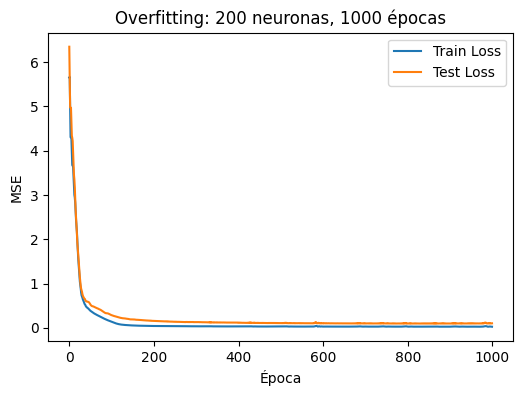

🔹 Overfitting: 200 neuronas, 1000 épocas
MSE entrenamiento: 0.0263
MSE test:          0.1024
----------------------------------------


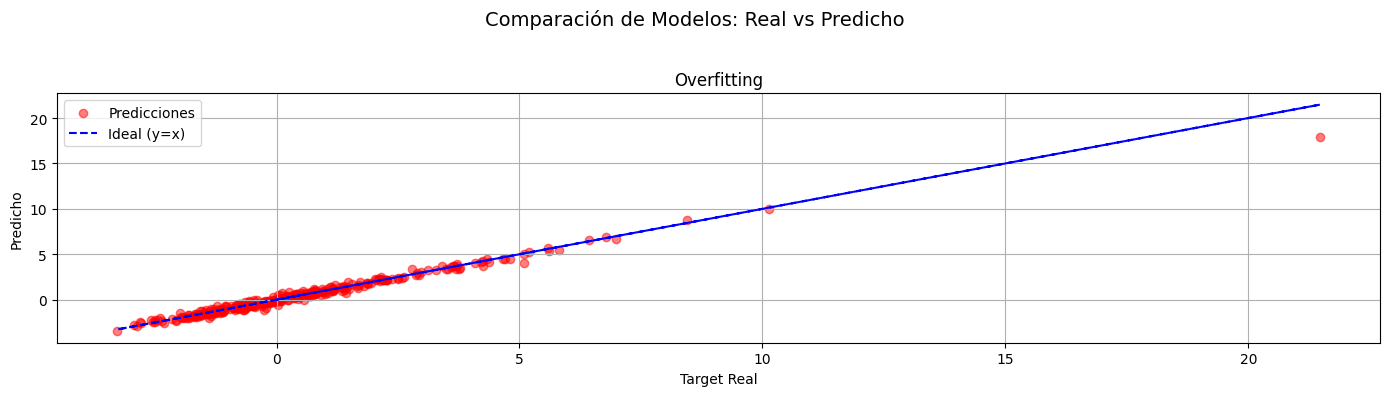

In [7]:
modelo_over = train_mlp(hidden_neurons=200, epochs=1000, lr=0.01, plot_title="Overfitting: 200 neuronas, 1000 épocas")
# Comparar en un gráfico 2D
comparar_modelos_2d(
    modelos=[modelo_over],
    nombres_modelos=["Overfitting"],
    X_test=X_test,
    y_test=y_test
)


📊 Análisis comparativo

Underfitting (2 neuronas, 10 épocas)	5.63	6.01	El error es alto tanto en entrenamiento como en test → la red no tiene capacidad suficiente para aprender la relación no lineal.


Aceptable (30 neuronas, 100 épocas, L2)	0.33	0.52	Excelente balance. El modelo generaliza bien, con una pequeña diferencia entre train/test. → Modelo óptimo.


Overfitting (200 neuronas, 1000 épocas)	0.025	0.12	Muy bajo error en train pero test empeora → el modelo memoriza los datos y pierde generalización.

🧠 Conclusión general

✅ El modelo aceptable logra un equilibrio óptimo entre complejidad y generalización.

❌ El underfitting demuestra poca capacidad de aprendizaje (red demasiado simple).

⚠️ El overfitting tiene demasiados parámetros y aprende ruido, perdiendo robustez.


### **3. Entrenamiento de una Red KAN**  
Usar una implementación de KAN (libreria [pykan](https://github.com/KindXiaoming/pykan)).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Red muy simple (ej: 1-2 neuronas por capa).  
   - Poca capacidad de aproximación.  

2. **Solución Aceptable:**  
   - Arquitectura equilibrada (ej: 4-5 neuronas por capa).  
   - Ajuste fino de hiperparámetros.  

3. **Overfitting:**  
   - Red muy profunda o con demasiadas neuronas.  
   - Entrenamiento prolongado sin early stopping.  

**Visualización:**  
- Graficar la función aprendida por KAN vs. los datos reales (en 2D si se proyecta una feature).  



In [8]:
!pip install pykan -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.8 MB/s eta 0:00:00


In [9]:
from kan import KAN
from kan.utils import create_dataset  # utilidades (según versión)
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [10]:
# Conversión de los datos

train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
test_input  = torch.tensor(X_test, dtype=torch.float32)
test_label  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

ds = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}


In [11]:
# Función de entrenamiento
def entrenar_kan(width, steps=100, lr=0.01, plot_name="KAN"):
    model = KAN(width=width)
    model.fit(ds, steps=steps, lr=lr)

    # Predicciones
    y_pred_train = model(train_input).detach().numpy().flatten()
    y_pred_test  = model(test_input).detach().numpy().flatten()

    # MSE
    mse_train = np.mean((y_pred_train - y_train) ** 2)
    mse_test  = np.mean((y_pred_test - y_test) ** 2)

    # Gráfico de comparación (2D)
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred_test, alpha=0.5, label="Test")
    plt.scatter(y_train, y_pred_train, alpha=0.3, label="Train")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel("Valores reales")
    plt.ylabel("Predicciones")
    plt.title(plot_name)
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()

    print(f"MSE Entrenamiento: {mse_train:.4f}")
    print(f"MSE Test:          {mse_test:.4f}")
    return model, mse_train, mse_test


🔹 Underfitting:
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.68e-01 | test_loss: 4.19e-01 | reg: 1.10e+01 | : 100%|█| 10/10 [00:02<00:00,  3.40it


saving model version 0.1


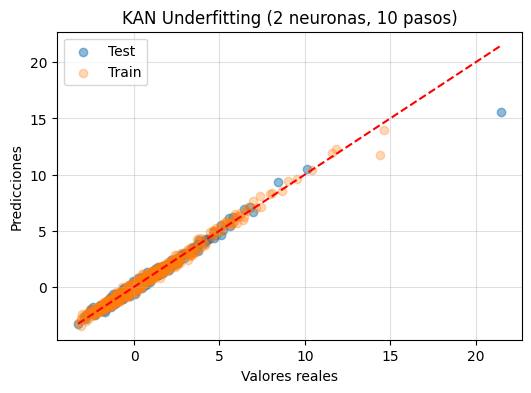

MSE Entrenamiento: 0.0720
MSE Test:          0.1753

🔹 Modelo Aceptable:
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.98e-01 | test_loss: 1.94e-01 | reg: 2.67e+01 | : 100%|█| 100/100 [00:23<00:00,  4.34


saving model version 0.1


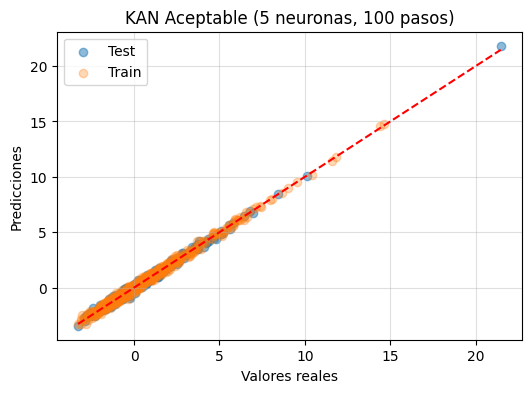

MSE Entrenamiento: 0.0391
MSE Test:          0.0377

🔹 Overfitting:
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.01e-01 | reg: 5.75e+01 | : 100%|█| 1000/1000 [03:59<00:00,  4.


saving model version 0.1


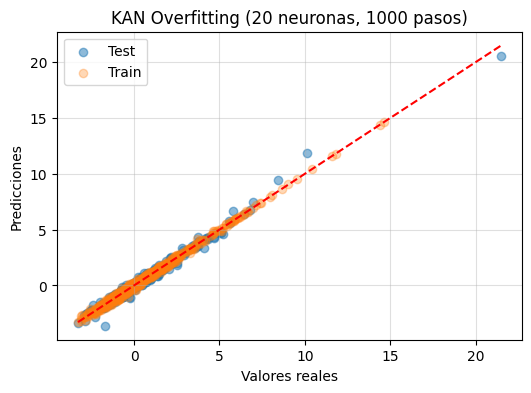

MSE Entrenamiento: 0.0227
MSE Test:          0.0904


In [12]:
# Configuraciones a probar

print("🔹 Underfitting:")
kan_under, mse_tr_u, mse_te_u = entrenar_kan(
    width=[4, 2, 1],
    steps=10,
    lr=0.01,
    plot_name="KAN Underfitting (2 neuronas, 10 pasos)"
)

print("\n🔹 Modelo Aceptable:")
kan_mid, mse_tr_m, mse_te_m = entrenar_kan(
    width=[4, 5, 1],
    steps=100,
    lr=0.01,
    plot_name="KAN Aceptable (5 neuronas, 100 pasos)"
)

print("\n🔹 Overfitting:")
kan_over, mse_tr_o, mse_te_o = entrenar_kan(
    width=[4, 20, 1],
    steps=1000,
    lr=0.005,
    plot_name="KAN Overfitting (20 neuronas, 1000 pasos)"
)

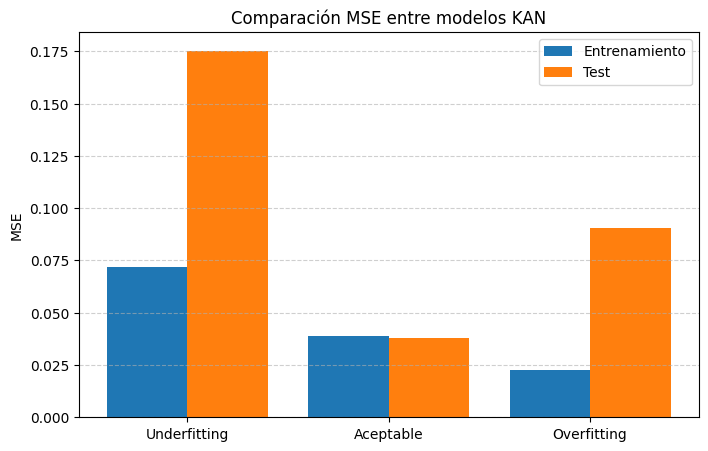

In [20]:
#  Comparación final

modelos = ["Underfitting", "Aceptable", "Overfitting"]
mse_train = [mse_tr_u, mse_tr_m, mse_tr_o]
mse_test  = [mse_te_u, mse_te_m, mse_te_o]

plt.figure(figsize=(8,5))
x = np.arange(len(modelos))
plt.bar(x - 0.2, mse_train, 0.4, label="Entrenamiento")
plt.bar(x + 0.2, mse_test, 0.4, label="Test")
plt.xticks(x, modelos)
plt.ylabel("MSE")
plt.title("Comparación MSE entre modelos KAN")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Conclusión sobre Redes KAN

Los resultados obtenidos muestran claramente el comportamiento esperado de las redes KAN frente a distintas configuraciones de complejidad y pasos de entrenamiento:

Underfitting (2 neuronas, 10 pasos): la red tiene poca capacidad de aproximación, por lo que no logra capturar completamente la relación no lineal del dataset. El error en test es significativamente mayor que en entrenamiento, evidenciando subajuste.

Solución aceptable (5 neuronas, 100 pasos): la red logra un equilibrio óptimo. El error en entrenamiento y test es bajo y muy cercano.

Overfitting (20 neuronas, 1000 pasos): la red comienza a memorizar los datos. Aunque el error en entrenamiento es muy bajo, el error en test aumenta.

#### **4. Conclusiones y Análisis**  
- Comparar **MLP vs KAN** en términos de:  
  - Capacidad de aproximación.  
  - Sensibilidad al overfitting/underfitting.  
  - Interpretabilidad (KAN permite visualizar funciones base).  
- Discutir:  
  - ¿Cuál modelo es más flexible?  
  - ¿En qué casos conviene usar KAN?  



## MLP vs KAN

Capacidad de aproximación: KAN captura mejor relaciones no lineales incluso con redes pequeñas; MLP necesita más neuronas y entrenamiento para igualar desempeño.

Sensibilidad al overfitting/underfitting: KAN es más robusta al underfitting y sobreajusta menos que la MLP en redes pequeñas; ambas pueden sobreajustar si la red es demasiado grande.

Interpretabilidad: KAN permite visualizar las funciones base, facilitando entender la contribución de cada feature; MLP es más “caja negra”.

Flexibilidad: KAN es más flexible para aproximar funciones complejas con menor tamaño de red.

Uso recomendado de KAN: Cuando se requiere buena aproximación de funciones no lineales con interpretabilidad y menor riesgo de underfitting, especialmente en datasets de tamaño moderado.


## **5- Referencias**

Utilice IA generativa (ChatGPT)
